# Youtube Sentiment Analysis



*   Test on 250 comments from english videos negative unbiased



In [1]:
import torch
import numpy as np
import pandas as pd
import nltk
import string
import regex as re
import spacy
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, pipeline

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def remove_emoji(comment):
    """Function to remove emojis.
        comment : data input ; str
        Taken from :
        https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

    """

    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', comment)

In [3]:
def P_data_reading(path, i=250):
    """Simple function to read in the data we want to use.
       path : the path pointing to our data ; csv file
    """
    comments_data = pd.read_csv(path)
    return comments_data.iloc[0:i,:]['Comment']

In [4]:
def P_data_cleaning(data, language):
    """Function to clean our data.
       data : data input ; pd.Series
       language : what language the comments are in (input in lowercase) : str
    """
    # REMOVING PUNCTUATION
    data = data.apply(lambda x: "".join([word for word in x.lower() if word not in string.punctuation]))

    # REMOVING EMOJIS
    data = data.apply(lambda x: remove_emoji(x))

    # LOWERCASE
    data = data.str.lower()

    # REMOVING STOPWORDS
    data = data.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words(language))]))



    return data

In [5]:
def P_data_lemmatizing(comment, language):
    """ Usefull for the sentiment analysis and the word cloud.
       comment : the current comment to analyze ; string
       language : the language for tokenization ; string
    """
    if language.lower() == 'english':
      lemmatizer = spacy.load("en_core_web_sm")


    lemmatized_comment = ' '.join([token.lemma_ for token in lemmatizer(comment)])


    # After lemmatizing, some words are again higher cased
    lemmatized_comment = lemmatized_comment.lower()


    return lemmatized_comment

In [6]:
def assign_label(row):
    if row['Positive Score'] == max(row['Positive Score'], row['Neutral Score'], row['Negative Score']):
        return 'Positive'
    elif row['Neutral Score'] == max(row['Positive Score'], row['Neutral Score'], row['Negative Score']):
        return 'Neutral'
    else:
        return 'Negative'

In [7]:
def P_data_word_count(data, i=25):
    """Usefull for the see the most frequent words.
       data : data input : pd.Series
    """
    # explode() : convert each single element into a row
    # We also sort them to find the most common ones
    word_counts = data.str.split().explode().value_counts().sort_values(ascending = False)





    # We return the count aswell as the (lemmatized) words themselves
    return word_counts.head(i)

In [8]:
# Define the path
path = 'Test_250.csv'

In [9]:
# Build the dataset
data = P_data_reading(path) # data is a Series

In [10]:
# Clean the dataset
data_cleaned = P_data_cleaning(data, language = 'english')

In [11]:
# Lemmatize the dataset
data_cleaned_lemmatized = data_cleaned.apply(lambda x : P_data_lemmatizing(x, language = 'english'))

In [12]:
# Load model
predict_sentiment = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    return_all_scores=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [13]:
# Turn the Series into a list
sentiment_results = predict_sentiment(list(data_cleaned_lemmatized))

In [14]:
# Prepare data for DataFrame
data = []
for sentiments in sentiment_results:
    positive_score = next((item['score'] for item in sentiments if item['label'] == 'positive'), None)
    neutral_score = next((item['score'] for item in sentiments if item['label'] == 'neutral'), None)
    negative_score = next((item['score'] for item in sentiments if item['label'] == 'negative'), None)
    data.append([positive_score, neutral_score, negative_score])

In [15]:
# Create DataFrame
output = pd.DataFrame(data, columns=['Positive Score', 'Neutral Score', 'Negative Score'])

In [16]:
# Add the comments
output['Comment'] = data_cleaned
output['Comment lemmatized'] = data_cleaned_lemmatized

In [17]:
# Add the labels
output['Label'] = output.apply(assign_label, axis=1)

In [18]:
# Order the colums
output = output[['Comment', 'Comment lemmatized', 'Positive Score', 'Neutral Score', 'Negative Score', 'Label']]

In [19]:
# Add the prediction to the dataset
csv_file = 'output.csv'
output.to_csv(csv_file, index = False)

<Axes: xlabel='Label'>

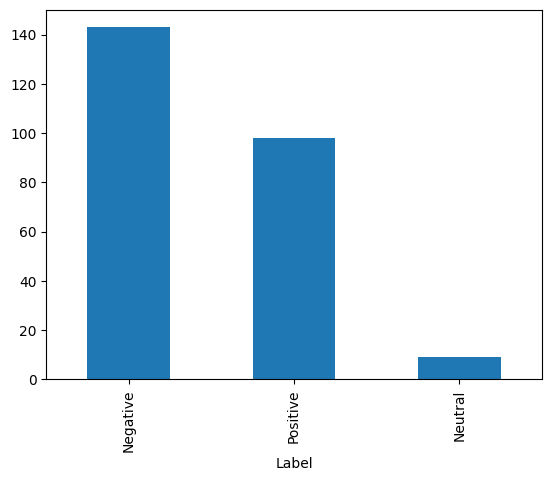

In [20]:
# Plot the number of labels
output['Label'].value_counts().plot(kind='bar')

In [23]:
# See the most frequent words
data_words_count = P_data_word_count(data_cleaned_lemmatized)
data_words_count

Comment
ai         247
not         83
like        64
people      61
do          59
need        53
use         40
human       37
bias        35
thing       33
make        32
one         28
we          27
would       26
problem     26
go          26
impact      25
work        25
model       24
say         23
well        22
could       22
real        21
think       21
create      20
Name: count, dtype: int64

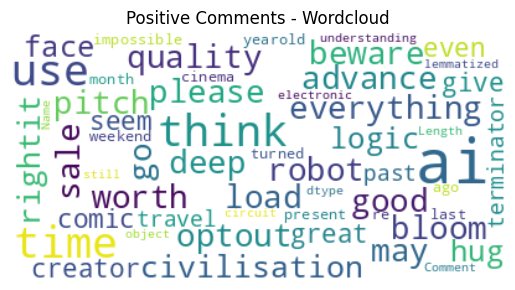

In [24]:
# Wordcloud with positive comments
positive_comments = output['Comment lemmatized'][output["Label"] == 'Positive']
stop_words = list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_comments))
plt.figure()
plt.title("Positive Comments - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

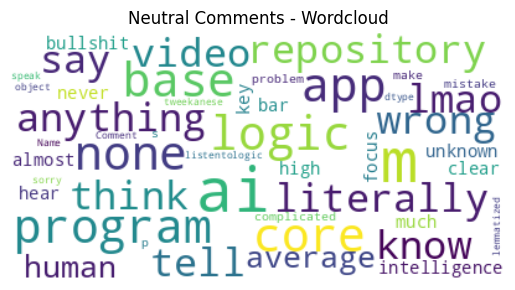

In [25]:
# Wordcloud with neutral comments
neutral_comments = output['Comment lemmatized'][output["Label"] == 'Neutral']
stop_words = list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(neutral_comments))
plt.figure()
plt.title("Neutral Comments - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

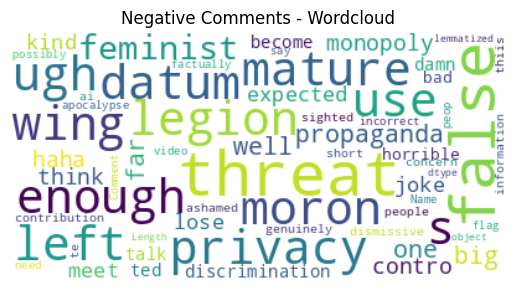

In [26]:
# Wordcloud with negative comments
negative_comments = output['Comment lemmatized'][output["Label"] == 'Negative']
stop_words = list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_comments))
plt.figure()
plt.title("Negative Comments - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()